In [1]:
root_path = 'C:\\Users\\polin\\Downloads\\projecto_final_OML\\projecto_final\\rumos_bank\\data\\'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

seed = 42

In [3]:
df = pd.read_csv(root_path + 'lending_data.csv')

In [4]:
df = df.drop('ID', axis = 1)

In [5]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = seed)

X_train = train_set.drop(['default.payment.next.month'], axis = 'columns')
y_train = train_set['default.payment.next.month']

X_test = test_set.drop(['default.payment.next.month'], axis = 1)
y_test = test_set['default.payment.next.month']

In [6]:
def total_cost(y_test, y_preds, threshold = 0.5):
    
    tn, fp, fn, tp = confusion_matrix(y_test == 1, y_preds > threshold).ravel()
    
    cost_fn = fn*3000
    cost_fp = fp*1000
    
    return cost_fn + cost_fp

In [7]:
def min_cost_threshold(y_test, y_preds):
    costs = {}
    for threshold in np.arange(0, 1.1, 0.1):
        costs[round(threshold, 1)] = total_cost(y_test, y_preds, threshold)
    min_threshold = min(costs, key=costs.get)
    return costs[min_threshold], min_threshold
    

In [8]:
import mlflow
from pathlib import Path

# Define the path where MLflow will store tracking data
# This is the directory where all the experiment data will be saved
uri = Path('C:\\Users\\polin\\Downloads\\projecto_final_OML\\projecto_final\\rumos_bank\\mlruns\\')

# Create the directory if it doesn't exist
uri.mkdir(parents=True, exist_ok=True)

# Convert the path to a URI
uri_as_uri = uri.as_uri()

# Set the MLflow tracking URI
#This line sets the tracking URI for MLflow. It tells MLflow where to store all the tracking data for experiments and runs. In this case, the data will be stored in the specified local directory.
mlflow.set_tracking_uri(uri_as_uri)

In [9]:
# Define MLflow Experiment for Logistic Regression
mlflow.set_experiment("Neural_Network_Experiment")

2024/06/08 16:34:10 INFO mlflow.tracking.fluent: Experiment with name 'Neural_Network_Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/polin/Downloads/projecto_final_OML/projecto_final/rumos_bank/mlruns/205396863580625281', creation_time=1717857250960, experiment_id='205396863580625281', last_update_time=1717857250960, lifecycle_stage='active', name='Neural_Network_Experiment', tags={}>

In [10]:
mlflow.end_run()

In [11]:

SEED = 42

# Concatenate X_train and y_train
train_data = pd.concat([X_train, y_train], axis=1)
train_dataset = mlflow.data.from_pandas(train_data, targets='default.payment.next.month', name="Rumos Bank Train Dataset")
mlflow.log_input(train_dataset, context="train")

# Concatenate X_test and y_test
test_data = pd.concat([X_test, y_test], axis=1)
test_dataset = mlflow.data.from_pandas(test_data, targets='default.payment.next.month', name="Rumos Bank Test Dataset")
mlflow.log_input(test_dataset, context="test")

# Log the seed parameter
mlflow.log_param("seed", SEED)


c:\Users\polin\miniconda3\envs\rumos_bank\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\polin\miniconda3\envs\rumos_bank\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data 

42

In [14]:
from sklearn.pipeline import Pipeline

mlp_model = MLPClassifier(solver = 'lbfgs',  random_state = seed, max_iter = 1000 )

mlp_pipeline = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
        ("MLP", mlp_model)
])

In [15]:
parameters = {'MLP__hidden_layer_sizes': [(20,), (20,10), (20, 10, 2)], 'MLP__learning_rate_init':[0.0001, 0.001, 0.01, 0.1]}

c:\Users\polin\miniconda3\envs\rumos_bank\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\polin\miniconda3\envs\rumos_bank\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these

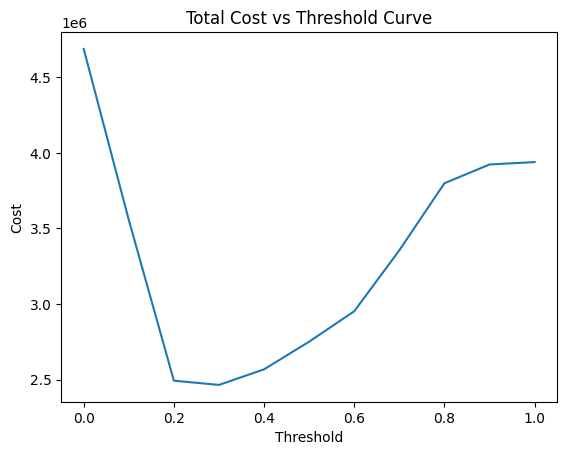

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

with mlflow.start_run(run_name="MLP Run", nested = True):
    # Train GridSearchCV with the pipeline
    clf_mlp = GridSearchCV(mlp_pipeline, parameters, cv=5, n_jobs=-1)
    clf_mlp.fit(X_train, y_train)
    
    # Predict probabilities for test data
    y_probs = clf_mlp.predict_proba(X_test)[:, 1]
    
    # Evaluate logistic regression model
    score = clf_mlp.score(X_test, y_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_probs > 0.5).ravel()
    
    # Calculate total cost and minimum cost threshold
    cost, min_threshold = total_cost(y_test, y_probs), min_cost_threshold(y_test, y_probs)
    
    # Log parameters, metrics, and model artifacts with MLflow
    mlflow.log_params(clf_mlp.best_params_)
    mlflow.log_metric("accuracy", score)
    mlflow.log_metric("total_cost", cost)
    mlflow.log_metric("min_cost_threshold", min_threshold[0])
    
    
    # Plot total cost vs threshold curve
    thresholds = np.arange(0, 1.1, 0.1)
    costs = [total_cost(y_test, y_probs, threshold) for threshold in thresholds]
    plt.plot(thresholds, costs)
    plt.ylabel('Cost')
    plt.xlabel('Threshold')
    plt.title('Total Cost vs Threshold Curve')
    plt.savefig('total_cost_vs_threshold.png')
    mlflow.log_artifact('total_cost_vs_threshold.png')

    # Log the final model
    mlflow.sklearn.log_model(clf_mlp.best_estimator_, artifact_path="mlp_pipeline", registered_model_name="MLP_test", input_example=X_train)

In [17]:
params=mlp_pipeline.get_params()
mlflow.log_params(params)
params


{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('MLP', MLPClassifier(max_iter=1000, random_state=42, solver='lbfgs'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'MLP': MLPClassifier(max_iter=1000, random_state=42, solver='lbfgs'),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'MLP__activation': 'relu',
 'MLP__alpha': 0.0001,
 'MLP__batch_size': 'auto',
 'MLP__beta_1': 0.9,
 'MLP__beta_2': 0.999,
 'MLP__early_stopping': False,
 'MLP__epsilon': 1e-08,
 'MLP__hidden_layer_sizes': (100,),
 'MLP__learning_rate': 'constant',
 'MLP__learning_rate_init': 0.001,
 'MLP__max_fun': 15000,
 'MLP__max_iter': 1000,
 'MLP__momentum': 0.9,
 'MLP__n_iter_no_change': 10,
 'MLP__nesterovs_momentum': True,
 'MLP__power_t': 0.5,
 'MLP__random_state': 42,
 'MLP__shuffle': True,
 'MLP__solver': 'lbfgs',
 'MLP__tol': 0.0001,
 'MLP__validation_fraction': 0.1,
 'MLP__verbose': False,
 'MLP__warm_start': False}

In [18]:
mlflow.end_run()